In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurements = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

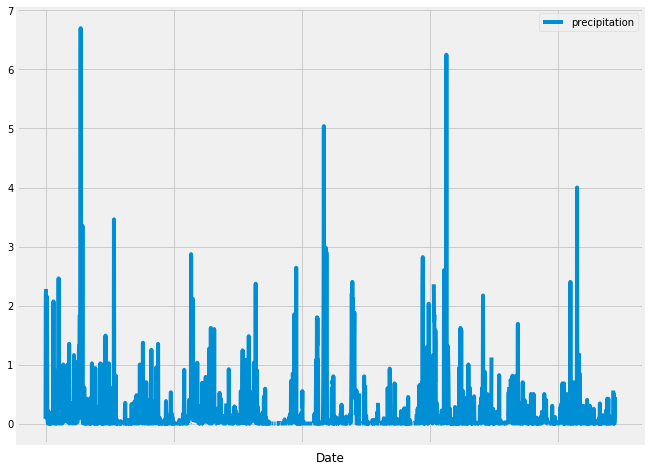

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_entry = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
last_year_data = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year_data).\
    order_by(Measurements.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precip_data_df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
precip_data_df.plot('Date', 'Precipitation', figsize=(10, 8))
plt.legend(["precipitation"])
plt.savefig("Precipitation.png")
plt.show()


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.id).count()
num_stations

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()
active_stations
    

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_stat = active_stations[0][0]
session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
                filter(Measurements.station == most_stat).all()


[(54.0, 71.66378066378067, 85.0)]

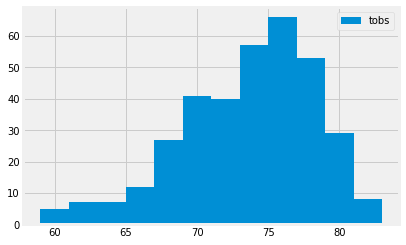

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obv = session.query(Measurements.station, Measurements.tobs).\
                filter(Measurements.station == most_stat).\
                filter(Measurements.date >= last_year_data).all()
temp_obv_df = pd.DataFrame(temp_obv, columns=['Temperature', 'Frequency'])
plt.hist(temp_obv_df['Frequency'],12)
plt.legend(["tobs"])
plt.savefig("temperatures.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_prev_yr = calc_temps('2012-02-28', '2012-03-05')
print(trip_prev_yr)
##### set up a dataframe with results where columns would be 'Min Temp' and 'Max Temp'
prev_yr_df = pd.DataFrame(trip_prev_yr)

#min_temp = trip_prev_yr.iloc[0]['Min Temp']
#max_temp = trip_prev_yr.iloc[0]['Max Temp']
#avg_temp = trip_prev_yr[1]
#diff_temp = max_temp - min_temp


[(62.0, 69.57142857142857, 74.0)]


AssertionError: 0 columns passed, passed data had 3 columns

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp.plot(kind='bar', yerr=diff_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title('Trip Avg Temp')
plt.ylabel('Avg Temp')
plt.savefig('avg_temp.png')
plt.show()


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
precip_data_stations = session.query(Measurement.station,Station.name, func.sum(Measurement.precip)).\
        filter(Measurement.station==Station.station).filter(Measurement.date > start_date, Measurement.date < end_date ).\
        group_by(Measurement.station).order_by(func.sum(Measurement.precip).desc()).all()

precip_data_stations


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
